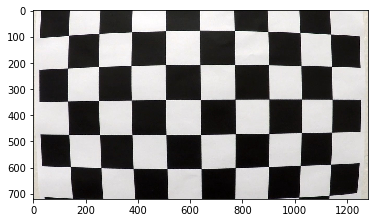

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
%matplotlib inline

# Read in images
images = glob.glob('camera_cal/calibration*.jpg')

# Arrays to store object points and image points from all images
objpoints = []  # 3D points in real world space
imgpoints = []  # 2D points in image plane

# Prepare object pints, like (0,0,0), (1,0,0), (2,0,0), ..., (9,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates
for image in images:
    # read in each image
    img = mpimg.imread(image)
    # convert to grayscale    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    # if corners are detected, add object points and image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

image = images[0]
img = mpimg.imread(image)
cv2.imwrite('output_images/0_calibration1_original.jpg', img)
plt.imshow(img)

Time elapsed: 1.0749


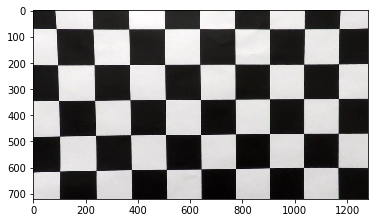

In [2]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
start = time.time()
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
print('Time elapsed: {:.4f}'.format(time.time() - start))
cv2.imwrite('output_images/0_calibration1_undistorted.jpg', undistorted)
plt.imshow(undistorted)

In [3]:
image = mpimg.imread('test_images/test3.jpg')
plt.imsave('output_images/1_original.jpg', image, format='jpg')
undistorted = cv2.undistort(image, mtx, dist, None, mtx)
plt.imsave('output_images/1_undistorted.jpg', undistorted, format='jpg')

In [4]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(v_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(v_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def hls_s_channel(img, s_thresh=(170, 255)):
    # img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    return s_binary

def hsv_v_channel(img, v_thresh=(20, 100)):
    # img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]

    # Threshold color channel
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel > v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    
    return v_binary

def rgb_r_channel(img, r_thresh=(20, 100)):
    r_channel = img[:,:,0]
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel > r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    return r_binary

def get_binary_image(undistorted):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=3, thresh=(30, 100))
    s_channel_binary = hls_s_channel(undistorted, s_thresh=(85, 255))
    r_channel_binary = rgb_r_channel(undistorted, r_thresh=(215, 255))
    
    combined = np.zeros_like(gradx)
    combined[(gradx == 1) | (s_channel_binary == 1) | (r_channel_binary == 1)] = 1
    return combined, gradx, s_channel_binary, r_channel_binary

Time elapsed: 0.0406


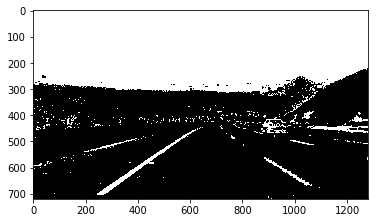

In [5]:
start = time.time()
combined, gradx, s_channel_binary, r_channel_binary = get_binary_image(undistorted)
print('Time elapsed: {:.4f}'.format(time.time() - start))

plt.imsave('output_images/1_gradx.jpg', gradx, format='jpg', cmap='gray')

plt.imsave('output_images/1_s_channel.jpg', s_channel_binary, format='jpg', cmap='gray')

#v_channel_binary = hsv_v_channel(undistorted, v_thresh=(215, 255))
#plt.imsave('output_images/1_v_channel.jpg', v_channel_binary, format='jpg', cmap='gray')

plt.imsave('output_images/1_r_channel.jpg', r_channel_binary, format='jpg', cmap='gray')

plt.imsave('output_images/1_combined.jpg', combined, format='jpg',cmap='gray')
plt.imshow(combined, cmap='gray')

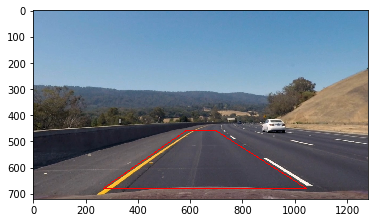

In [6]:
def get_source_rectangle_points():
    # the points are detected on the undistorted test image with straight lines
    src_bottom_left = [267, 680]
    src_top_left = [583, 460]
    src_top_right = [700, 460]
    src_bottom_right = [1046, 680]

    src_rectangle_points = np.array(np.float32([src_bottom_left, src_top_left, src_top_right, src_bottom_right]))
    return src_rectangle_points

src_rectangle_points = get_source_rectangle_points()

def get_destination_rectangle_points():
    dst_bottom_left = [320, 720] 
    dst_top_left = [320, 1]
    dst_top_right = [920, 1]
    dst_bottom_right = [920, 720]

    dst_rectangle_points = np.array(np.float32([dst_bottom_left, dst_top_left, dst_top_right, dst_bottom_right]))
    return dst_rectangle_points

dst_rectangle_points = get_destination_rectangle_points()

# Draw a rectangle on the undistorted image
undistorted_rectangle = np.copy(undistorted)
color = [255, 0, 0]
thickness = 2
cv2.line(undistorted_rectangle, tuple(src_rectangle_points[0]), tuple(src_rectangle_points[1]), color, thickness)
cv2.line(undistorted_rectangle, tuple(src_rectangle_points[1]), tuple(src_rectangle_points[2]), color, thickness)
cv2.line(undistorted_rectangle, tuple(src_rectangle_points[2]), tuple(src_rectangle_points[3]), color, thickness)
cv2.line(undistorted_rectangle, tuple(src_rectangle_points[3]), tuple(src_rectangle_points[0]), color, thickness)
plt.imshow(undistorted_rectangle)
plt.imsave('output_images/2_undistorted_rectangle.jpg', undistorted_rectangle, format='jpg', cmap='gray')

Time elapsed: 0.0171


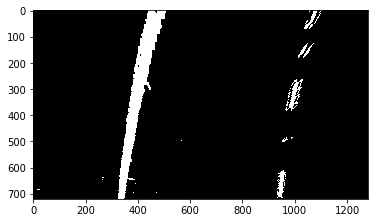

In [7]:
def corners_unwarp(undist, src, dst):
    # Get M, the transform matrix, and Minv, the inverse transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image to a top-down view
    warped = cv2.warpPerspective(undist, M, (undist.shape[1], undist.shape[0]), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

start = time.time()
binary_warped, M, Minv = corners_unwarp(combined, src_rectangle_points, dst_rectangle_points)
print('Time elapsed: {:.4f}'.format(time.time() - start))
plt.imshow(binary_warped, cmap='gray')
plt.savefig('output_images/2_warped.jpg')

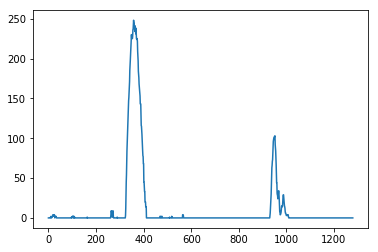

In [8]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.savefig('output_images/3_histogram.jpg')

[  1.14451852e-04  -2.69335763e-01   4.71662936e+02] [  1.64238018e-04  -3.06979751e-01   1.07934560e+03]
Time elapsed: 0.0302


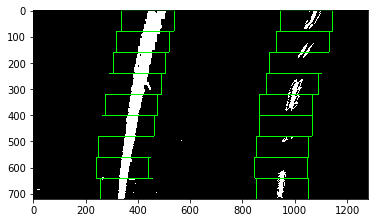

In [9]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
import pdb
#pdb.set_trace()
start = time.time()
def find_base(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base, rightx_base

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

leftx_base, rightx_base = find_base(binary_warped)

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
print(left_fit, right_fit)
print('Time elapsed: {:.4f}'.format(time.time() - start))
plt.imshow(out_img)
plt.savefig('output_images/3_detected_windows.jpg')

720
1280


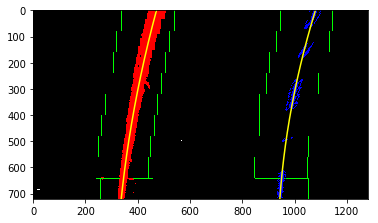

In [10]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
print(binary_warped.shape[0])
print(binary_warped.shape[1])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('output_images/3_detected_lines.jpg')

(720, 0)

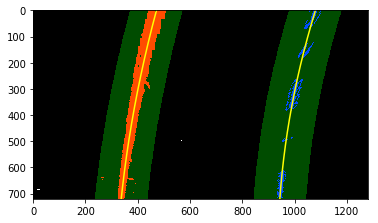

In [11]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [12]:
def get_curvature(ploty, leftx, lefty, rightx, righty, left_fitx, right_fitx):
    line_width = 3.7 # meters
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3/60 # meters per pixel in y dimension
    xm_per_pix = line_width/600 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    x_fit_pix = np.array([(binary_warped.shape[1]//2 - left_fitx[-1]) * xm_per_pix - line_width, 
                          line_width - (right_fitx[-1] - binary_warped.shape[1]//2) * xm_per_pix])
    x_offset = np.mean(x_fit_pix)
    
    return left_curverad, right_curverad, x_offset
# Now our radius of curvature is in meters
start = time.time()
left_curverad, right_curverad, x_offset = get_curvature(ploty, leftx, lefty, rightx, righty, left_fitx, right_fitx)
print('Time elapsed: {:.4f}'.format(time.time() - start))
print(left_curverad, 'm', right_curverad, 'm')
print(x_offset, 'm')


Time elapsed: 0.0119
1771.51747969 m 1234.34204193 m
-0.00218753474992 m


Time elapsed: 0.0358


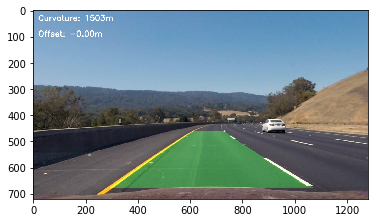

In [13]:
def draw_image(binary_warped, undistorted, left_fitx, right_fitx, ploty, Minv, leftx, lefty, rightx, righty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted.shape[1], undistorted.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    left_curverad, right_curverad, x_offset = get_curvature(ploty, leftx, lefty, rightx, righty, left_fitx, right_fitx)

    font = cv2.FONT_HERSHEY_SIMPLEX
    result = cv2.putText(result, 'Curvature: {:.0f}'.format(np.mean([left_curverad, right_curverad])) + 'm', 
                         (20,40), font, 1, (255,255,255), 2, cv2.LINE_AA)
    result = cv2.putText(result, 'Offset: {:+.2f}'.format(x_offset) + 'm', 
                         (20,100), font, 1, (255,255,255), 2, cv2.LINE_AA)
    
    return result

start = time.time()
result = draw_image(binary_warped, undistorted, left_fitx, right_fitx, ploty, Minv,
                    leftx, lefty, rightx, righty)
print('Time elapsed: {:.4f}'.format(time.time() - start))
plt.imshow(result)
plt.imsave('output_images/4_final_result.jpg', result, format='jpg', cmap='gray')

In [14]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        self.fit_array = np.zeros((5,3))
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
left_line = Line()
right_line = Line()

def get_binary_warped(combined):
    src_rectangle_points = get_source_rectangle_points()
    dst_rectangle_points = get_destination_rectangle_points()
    binary_warped, M, Minv = corners_unwarp(combined, src_rectangle_points, dst_rectangle_points)
    return binary_warped, Minv

In [15]:
def process_image(image):
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    
    combined = get_binary_image(undistorted)[0]
    
    binary_warped, Minv = get_binary_warped(combined)
    
    leftx_base, rightx_base = find_base(binary_warped)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if (np.mean(right_fitx - left_fitx) > 590) | (np.mean(right_fitx - left_fitx) < 610):
        if left_line.detected == False:
            left_line.fit_array[:] = left_fit
            right_line.fit_array[:] = right_fit

            left_line.detected = True
        else:
            left_line.fit_array = np.roll(left_line.fit_array, 1, axis=0)
            left_line.fit_array[0] = left_fit

            right_line.fit_array = np.roll(right_line.fit_array, 1, axis=0)
            right_line.fit_array[0] = right_fit
        
    left_fit = np.mean(left_line.fit_array, axis=0)
    right_fit = np.mean(right_line.fit_array, axis=0)
    
    # Generate x and y values for plotting
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    result = draw_image(binary_warped, undistorted, left_fitx, right_fitx, ploty, Minv,
                        leftx, lefty, rightx, righty)
    
    #font = cv2.FONT_HERSHEY_SIMPLEX
    #result = cv2.putText(result, str(left_line.detected), 
    #                     (20,100), font, 1, (255,255,255), 2, cv2.LINE_AA)
    return result

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

file_name = "project_video"
#file_name = "challenge_video"

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip = VideoFileClip(file_name + ".mp4").subclip(35,43)
#clip = VideoFileClip(file_name + ".mp4").subclip(0,5)
clip = VideoFileClip(file_name + ".mp4")
white_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(file_name + "_output.mp4", audio=False)